# Определение возраста покупателей

## Исследовательский анализ данных

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 
В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

## План работы:

1. Провести исследовательский анализ данных из датасета с реальным возрастом покупателей.
2. Визуально посмотреть часть фото и сопоставить, можно ли визуально определить возраст людей с фото достаточно точно.
3. Обучить модель на основе ResNet50 определять возраст людей с фото. Добиться метрики МАЕ не выше 8.

#### Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.shape

(7591, 2)

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Минимальный возраст-1 год, макцимальный-100 лет. Посмотрим распределение количества фото по возрастам:

In [7]:
labels.pivot_table(index='real_age', values='file_name', aggfunc='count')

,file_name
real_age,
1,149
2,88
3,25
4,101
5,87
...,...
94,5
95,2
96,2


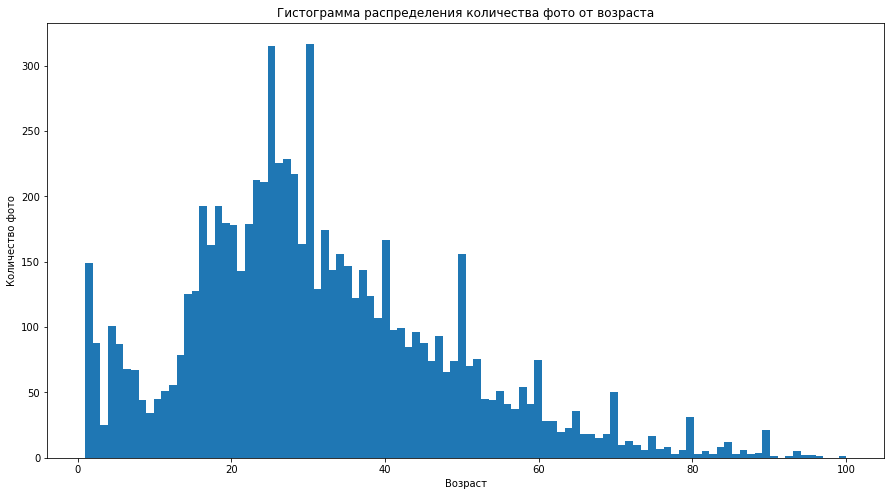

In [8]:
plt.figure(figsize=[15,8])

plt.hist(labels['real_age'], bins=100)

plt.xlabel("Возраст")
plt.ylabel("Количество фото")

plt.title("Гистограмма распределения количества фото от возраста")
plt.show()

Можно обратить внимание, что в начале каждого десятка отсчета на гистограме присутствуют пики. Это может означать, что какая-то часть фото была разделена по категориям или разметчик не знал реальны возраст и возраст на этих фото может быть не точным. Этот факт может помешать процессу обучения и несколько увеличить ошибку.
Больше всего фотографий имеется для людей 26-31. Самые опасные для кассиров в плане покупки алкоголя-подростки 13-17 лет, посмотрим этот срез по количеству.

In [9]:
labels[(labels['real_age'] >= 13) & (labels['real_age'] < 18)].pivot_table(index='real_age', values='file_name', aggfunc='count')

,file_name
real_age,
13,79
14,125
15,128
16,193
17,163


In [10]:
labels[(labels['real_age'] >= 13) & (labels['real_age'] < 18)].pivot_table(index='real_age', values='file_name', aggfunc='count').sum()

file_name    688
dtype: int64

Не слишком много для анализа данных, менее 10% от всего датасета.

Загрузим на экран несколько фото и посмотрим, можно ли глазами определить и сопоставить реальный фозраст и возраст на фото:

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw")

Found 7591 validated image filenames.


In [12]:
file, labels=next(datagen_flow)

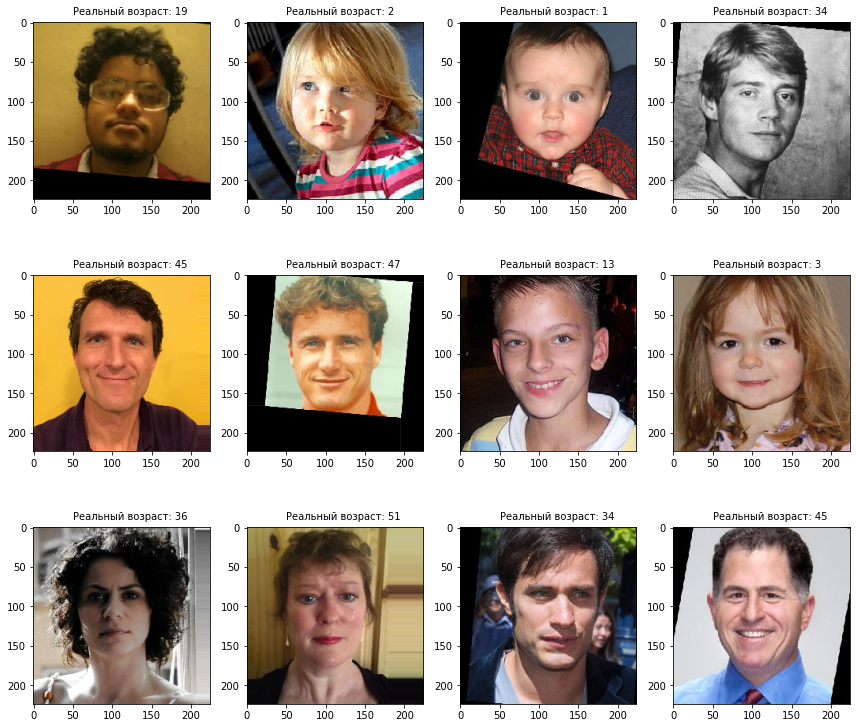

In [13]:
fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(file[i])
    plt.xticks()
    plt.yticks()
    plt.tight_layout()
    # Добавляем подписи к каждому изображению
    plt.text(50, -10,f"Реальный возраст: {labels[i]}")

Визуально довольно сложно сопоставить фото человека с реальным возрастом. Я бы смогла это сделать только для детей до года, а с остальными фото-с точностью +-2 - 5 лет в зависимости от возраста.

Общая ориентация фото-прямая, лицо расположено примерно по центру, все фото цветные. Для хорошего убучения их можно попробовать отражать по вертикальной оси.  

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    
    labels_df = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        height_shift_range=0.10,
        width_shift_range=0.10)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset='training',
        seed=12345
    )
    
    return train_datagen_flow

def load_test(path):
    
    labels_df = pd.read_csv(path + 'labels.csv')
    
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset='validation',
        seed=12345)
    
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer=Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-07-10 13:31:04.538831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-10 13:31:04.986592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 103s - loss: 248.7156 - mae: 11.4098 - val_loss: 1011.7246 - val_mae: 27.1239
Epoch 2/10
178/178 - 98s - loss: 88.9836 - mae: 7.1243 - val_loss: 975.6638 - val_mae: 26.5308
Epoch 3/10
178/178 - 98s - loss: 68.2646 - mae: 6.2849 - val_loss: 347.0817 - val_mae: 13.9003
Epoch 4/10
178/178 - 99s - loss: 53.7979 - mae: 5.6329 - val_loss: 122.4534 - val_mae: 8.3219
Epoch 5/10
178/178 - 99s - loss: 42.8871 - mae: 5.0716 - val_loss: 98.0747 - val_mae: 7.5321
Epoch 6/10
178/178 - 98s - loss: 36.6336 - mae: 4.6453 - val_loss: 71.9281 - val_mae: 6.1922
Epoch 7/10
178/178 - 98s - loss: 34.0935 - mae: 4.5059 - val_loss: 73.1189 - val_mae: 6.3578
Epoch 8/10
178/178 - 102s - loss: 29.4774 - mae: 4.2028 - val_loss: 69.2139 - val_mae: 6.1344
Epoch 9/10
178/178 - 102s - loss: 24.8352 - mae: 3.8715 - val_loss: 64.5453 - val_mae: 5.9515
Epoch 10/10
178/178 - 101s - loss: 22.3710 - mae: 3.6642 - val_loss: 66.9742 - val_mae: 6.0007
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 66.9742 - mae: 6.0007
Test MAE: 6.0007



```

## Анализ обученной модели

В ходе работы была обучена модель ResNet50, которая на 10 эпохах дала на тестовой выборке MAE=6.0007. Такая модель точно не подходит для проверки кассиров при продаже алкоголя-слишком уж велика ошибка, но может помочь в рекомендациях товаров покупателям-деление на возрастные группы с такое метрикой пройдет хорошо.

Для улучшения качетва обучения можно попробовать большее количество эпох обучения, а так же можно попробовать заменить ResNet50 на ResNet101.